# Michell Luiz Costalonga

# Exercícios - Módulo 15
<br><br>

# Exercício: Sistemas de Recomendação

<br>

__Introdução: o objetivo deste exercício é discutirmos uma metodologia de avaliação de filtros colaborativos.__

<br>

Para isso, utilize a função getData() para carregar os dados: 

    - teremos avaliações que 367 usuários fizeram a respeito de 80 filmes. As notas variam entre 1, 2, 3, 4, e 5. 
    
    - os valores NaN representam filmes que ainda não foram avaliados pelos usuários.

Como __modelo__ para as recomendações, usaremos a __fatoração matricial.__ Use a classe MatrixFactorization() construída ao longo do módulo.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def getData():
    r_cols = ['user_id', 'movie_id', 'rating', 'unix_timestamp']
    ratings = pd.read_csv('u.data', sep='\t', names=r_cols,
                          encoding='latin-1')
    m_cols = ['movie_id', 'title', 'release_date', 'video_release_date', 'imdb_url']
    movies = pd.read_csv('u.item', sep='|', names=m_cols, usecols=range(5),
                         encoding='latin-1')
    movie_ratings = pd.merge(movies, ratings)
    temp = movie_ratings[['movie_id', 'user_id', 'rating']].copy()
    temp = temp.pivot_table(columns='movie_id', index='user_id', values='rating').copy()
    temp.index = ['User_'+str(int(i)) for i in temp.index]
    temp.columns = ['Filme_'+str(int(i)) for i in temp.columns]
    qtd_cols = 80
    R = temp.iloc[:, :qtd_cols]
    l=[]
    for i in range(1, R.shape[0]+1):
        if R.iloc[i-1, ].isnull().sum() >= (qtd_cols - 10):
            l.append(i)
    R = R.drop(["User_"+str(r) for r in l])
    R.index = ['User_'+str(int(i)) for i in range(R.shape[0])]
    return R

In [3]:
import time

class MatrixFactorization():
    
    def __init__(self, dataframe, K, steps, alpha, beta):
        self.df = dataframe
        self.K = K
        self.steps = steps
        self.alpha = alpha
        self.beta = beta
        
    def fit(self):
        t0 = time.time()
        
        R = self.df.values
        N, M = R.shape
        
        #inicio aleatorio
        P = np.random.rand(N,self.K)
        Q = np.random.rand(self.K,M)
        
        lista_erro_step = []
        
        #loop
        for step in range(self.steps):
            
            mse_total_step = 0
            #varrendo todas as entradas da matriz R
            for i in range(len(R)):
                for j in range(len(R[i])):
                    #validando se o valor associado está preenchido
                    if R[i][j] > 0:

                        #calculando o erro:
                        eij = R[i][j] - np.dot(P[i,:],Q[:,j])
                        mse_total_step += (eij)**2
                        #alterando os valores
                        for k in range(self.K):
                            P[i][k] = P[i][k] + self.alpha * ( 2 * eij * Q[k][j] - self.beta * P[i][k])
                            Q[k][j] = Q[k][j] + self.alpha * ( 2 * eij * P[i][k] - self.beta * Q[k][j])
                            
            lista_erro_step.append(mse_total_step)
            
        self.P = P
        self.Q = Q
        self.lista_erro_step = lista_erro_step
        t1 = time.time()
        print("Fatoração concluída. Tempo aproximado:", int(t1-t0), 'segundos.')
        
    def predict(self):
        return self.P.dot(self.Q)
    
    def print_MSE_steps(self):
        plt.figure(figsize=[15,6])
        plt.title("Custo total por Step", fontsize = 16, fontweight = 'bold')
        plt.xlabel("Step", fontsize = 14, fontweight = 'bold')
        plt.ylabel("Erro", fontsize = 14, fontweight = 'bold')
        plt.plot(range(1, 1+self.steps), self.lista_erro_step, c = 'blue', lw = 2)
        plt.grid()
        plt.show()

<br><br>

Tradicionalmente, para avaliarmos a performance de algoritmos de machine learning, fazemos a divisão dos dados em treino/teste; os dados de teste são utilizados no modelo final, apenas para validar que o mesmo não está sofrendo overfitting e está generalizando bem.

No contexto dos filtros colaborativos, tal divisão dos dados não fará sentido: os métodos discutidos (de filtragem colaborativa) usam as informações de interação dos usuários com itens para "preencher os valores faltantes" da matriz de interação. Esse preenchimento é justamente a recomendação!

<br>

No entanto, podemos aplicar uma __metodologia que "simula" dados de treino/teste.__ 

Essencialmente, essa metodologia consiste de criar uma base de treino em que retiramos algumas interações dos usuários. Dessa forma, os modelos irão aprender os padrões dos dados sem terem acesso a toda informação.

Nos dados de teste, usaremos essas interações retiradas em treino para avaliar os resultados.

<br>

__Considere o exemplo:__

Vamos carregar, novamente, o dataset que usamos ao longo do módulo:

In [4]:
def getDF():
    dic__ = {"User_1":[np.nan, np.nan, np.nan, 1, 7, 2, 3, 8],
         "User_2":[9,10,2,2,6,5,3,8],
         "User_3":[4, 7, 9, 6,6,10,10,2],
         "User_4":[np.nan, 7, 9, 5, 5, 10, 9, 1],
         "User_5":[7.0,6.0,3.0,8.0,3,4.0,3.0, 2],
         "User_6":[np.nan, np.nan, 9, 9,6,8,9,np.nan],
         "User_7":[3,5,4,4,3,3,9,np.nan],
         "User_8":[10,10,10,10,2,2,2,2],
         "User_9":[9,9,np.nan,8,3,3,1,np.nan],
         "User_10":[9,8,10,9,3,4,2,1],
         "User_11":[4,4,3,3,9,9,8,10],
         "User_12":[2,2,4,1,8,10,10,9],
         "User_13":[1,4,1,3,7,10,7,8],
         "User_14":[3,3,2,1,1,10, np.nan,10],
         "User_15":[9,9,8,10,4,2,np.nan,1]
        }
    df = pd.DataFrame(dic__).T
    df.columns = ['Filme_'+str(int(i+1)) for i in range(8)]
    return df

In [5]:
df = getDF()
df

,Filme_1,Filme_2,Filme_3,Filme_4,Filme_5,Filme_6,Filme_7,Filme_8
User_1,NaN,NaN,NaN,1.0,7.0,2.0,3.0,8.0
User_2,9.0,10.0,2.0,2.0,6.0,5.0,3.0,8.0
User_3,4.0,7.0,9.0,6.0,6.0,10.0,10.0,2.0
User_4,NaN,7.0,9.0,5.0,5.0,10.0,9.0,1.0
User_5,7.0,6.0,3.0,8.0,3.0,4.0,3.0,2.0
User_6,NaN,NaN,9.0,9.0,6.0,8.0,9.0,NaN
User_7,3.0,5.0,4.0,4.0,3.0,3.0,9.0,NaN
User_8,10.0,10.0,10.0,10.0,2.0,2.0,2.0,2.0
User_9,9.0,9.0,NaN,8.0,3.0,3.0,1.0,NaN
User_10,9.0,8.0,10.0,9.0,3.0,4.0,2.0,1.0


<br>

Abaixo, criamos o array "ratings", que consiste de nossa matriz de interação usuário/item. No entanto, fizemos um completamento com "0" nos dados faltantes. Dessa forma, o rating = 0 significa que o usuário não avaliou o filme em questão.

<br>

In [6]:
ratings = df.fillna(0).values
ratings

array([[ 0.,  0.,  0.,  1.,  7.,  2.,  3.,  8.],
       [ 9., 10.,  2.,  2.,  6.,  5.,  3.,  8.],
       [ 4.,  7.,  9.,  6.,  6., 10., 10.,  2.],
       [ 0.,  7.,  9.,  5.,  5., 10.,  9.,  1.],
       [ 7.,  6.,  3.,  8.,  3.,  4.,  3.,  2.],
       [ 0.,  0.,  9.,  9.,  6.,  8.,  9.,  0.],
       [ 3.,  5.,  4.,  4.,  3.,  3.,  9.,  0.],
       [10., 10., 10., 10.,  2.,  2.,  2.,  2.],
       [ 9.,  9.,  0.,  8.,  3.,  3.,  1.,  0.],
       [ 9.,  8., 10.,  9.,  3.,  4.,  2.,  1.],
       [ 4.,  4.,  3.,  3.,  9.,  9.,  8., 10.],
       [ 2.,  2.,  4.,  1.,  8., 10., 10.,  9.],
       [ 1.,  4.,  1.,  3.,  7., 10.,  7.,  8.],
       [ 3.,  3.,  2.,  1.,  1., 10.,  0., 10.],
       [ 9.,  9.,  8., 10.,  4.,  2.,  0.,  1.]])

<br>

Na sequência, apresentamos a função que faz a divisão dos dados em treino e teste.

<br>

In [7]:
def train_test_split(ratings, qtd):
    test = np.zeros(ratings.shape)
    train = ratings.copy()
    for user in range(ratings.shape[0]):
        test_ratings = np.random.choice(ratings[user, :].nonzero()[0], 
                                        size=qtd, 
                                        replace=False)
        train[user, test_ratings] = 0.
        test[user, test_ratings] = ratings[user, test_ratings]
        
    return train, test

In [8]:
train, test = train_test_split(ratings, qtd = 2)

<br>

__Vamos comparar os dados de treino e teste com os dados originais:__
    
<br>

In [9]:
#matriz de interação - original;

ratings

array([[ 0.,  0.,  0.,  1.,  7.,  2.,  3.,  8.],
       [ 9., 10.,  2.,  2.,  6.,  5.,  3.,  8.],
       [ 4.,  7.,  9.,  6.,  6., 10., 10.,  2.],
       [ 0.,  7.,  9.,  5.,  5., 10.,  9.,  1.],
       [ 7.,  6.,  3.,  8.,  3.,  4.,  3.,  2.],
       [ 0.,  0.,  9.,  9.,  6.,  8.,  9.,  0.],
       [ 3.,  5.,  4.,  4.,  3.,  3.,  9.,  0.],
       [10., 10., 10., 10.,  2.,  2.,  2.,  2.],
       [ 9.,  9.,  0.,  8.,  3.,  3.,  1.,  0.],
       [ 9.,  8., 10.,  9.,  3.,  4.,  2.,  1.],
       [ 4.,  4.,  3.,  3.,  9.,  9.,  8., 10.],
       [ 2.,  2.,  4.,  1.,  8., 10., 10.,  9.],
       [ 1.,  4.,  1.,  3.,  7., 10.,  7.,  8.],
       [ 3.,  3.,  2.,  1.,  1., 10.,  0., 10.],
       [ 9.,  9.,  8., 10.,  4.,  2.,  0.,  1.]])

In [10]:
#dados de treino;
#observe que, para cada usuário (ou seja, para cada linha) 3 notas foram retiradas!! 
#ou seja, foram substituida por 0.

train

array([[ 0.,  0.,  0.,  0.,  7.,  2.,  3.,  0.],
       [ 9.,  0.,  2.,  2.,  0.,  5.,  3.,  8.],
       [ 4.,  0.,  9.,  6.,  6., 10.,  0.,  2.],
       [ 0.,  7.,  0.,  5.,  5.,  0.,  9.,  1.],
       [ 7.,  6.,  3.,  8.,  3.,  4.,  0.,  0.],
       [ 0.,  0.,  9.,  0.,  6.,  0.,  9.,  0.],
       [ 3.,  5.,  4.,  4.,  3.,  0.,  0.,  0.],
       [10.,  0., 10.,  0.,  2.,  2.,  2.,  2.],
       [ 9.,  9.,  0.,  0.,  0.,  3.,  1.,  0.],
       [ 9.,  8.,  0.,  0.,  3.,  4.,  2.,  1.],
       [ 4.,  4.,  3.,  3.,  0.,  9.,  0., 10.],
       [ 0.,  2.,  4.,  1.,  8.,  0., 10.,  9.],
       [ 0.,  4.,  1.,  3.,  7., 10.,  7.,  0.],
       [ 3.,  3.,  2.,  0.,  0., 10.,  0., 10.],
       [ 9.,  0.,  8.,  0.,  4.,  2.,  0.,  1.]])

In [11]:
#dados de teste;
#observe que exatamente as notas que foram retiradas de treino são colocadas nessa matriz de teste!!

test

array([[ 0.,  0.,  0.,  1.,  0.,  0.,  0.,  8.],
       [ 0., 10.,  0.,  0.,  6.,  0.,  0.,  0.],
       [ 0.,  7.,  0.,  0.,  0.,  0., 10.,  0.],
       [ 0.,  0.,  9.,  0.,  0., 10.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  3.,  2.],
       [ 0.,  0.,  0.,  9.,  0.,  8.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  3.,  9.,  0.],
       [ 0., 10.,  0., 10.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  8.,  3.,  0.,  0.,  0.],
       [ 0.,  0., 10.,  9.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  9.,  0.,  8.,  0.],
       [ 2.,  0.,  0.,  0.,  0., 10.,  0.,  0.],
       [ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  8.],
       [ 0.,  0.,  0.,  1.,  1.,  0.,  0.,  0.],
       [ 0.,  9.,  0., 10.,  0.,  0.,  0.,  0.]])

<br>

Na prática, usaremos os dados de treino para treinar e escolher os modelos.

Neste caso, podemos, inclusive, fazer a divisão em treino/validação/teste:
    


In [12]:
train, val = train_test_split(train, qtd = 2)

In [13]:
train

array([[ 0.,  0.,  0.,  0.,  0.,  0.,  3.,  0.],
       [ 9.,  0.,  2.,  2.,  0.,  0.,  3.,  0.],
       [ 4.,  0.,  0.,  6.,  6.,  0.,  0.,  2.],
       [ 0.,  7.,  0.,  5.,  0.,  0.,  9.,  0.],
       [ 7.,  6.,  3.,  0.,  3.,  0.,  0.,  0.],
       [ 0.,  0.,  9.,  0.,  0.,  0.,  0.,  0.],
       [ 3.,  0.,  4.,  0.,  3.,  0.,  0.,  0.],
       [ 0.,  0., 10.,  0.,  0.,  2.,  2.,  2.],
       [ 0.,  9.,  0.,  0.,  0.,  3.,  0.,  0.],
       [ 9.,  0.,  0.,  0.,  3.,  4.,  0.,  1.],
       [ 0.,  0.,  3.,  3.,  0.,  9.,  0., 10.],
       [ 0.,  2.,  4.,  0.,  8.,  0.,  0.,  9.],
       [ 0.,  4.,  1.,  0.,  7., 10.,  0.,  0.],
       [ 0.,  3.,  2.,  0.,  0.,  0.,  0., 10.],
       [ 0.,  0.,  8.,  0.,  0.,  2.,  0.,  1.]])

In [14]:
val

array([[ 0.,  0.,  0.,  0.,  7.,  2.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  5.,  0.,  8.],
       [ 0.,  0.,  9.,  0.,  0., 10.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  5.,  0.,  0.,  1.],
       [ 0.,  0.,  0.,  8.,  0.,  4.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  6.,  0.,  9.,  0.],
       [ 0.,  5.,  0.,  4.,  0.,  0.,  0.,  0.],
       [10.,  0.,  0.,  0.,  2.,  0.,  0.,  0.],
       [ 9.,  0.,  0.,  0.,  0.,  0.,  1.,  0.],
       [ 0.,  8.,  0.,  0.,  0.,  0.,  2.,  0.],
       [ 4.,  4.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  1.,  0.,  0., 10.,  0.],
       [ 0.,  0.,  0.,  3.,  0.,  0.,  7.,  0.],
       [ 3.,  0.,  0.,  0.,  0., 10.,  0.,  0.],
       [ 9.,  0.,  0.,  0.,  4.,  0.,  0.,  0.]])

In [15]:
test

array([[ 0.,  0.,  0.,  1.,  0.,  0.,  0.,  8.],
       [ 0., 10.,  0.,  0.,  6.,  0.,  0.,  0.],
       [ 0.,  7.,  0.,  0.,  0.,  0., 10.,  0.],
       [ 0.,  0.,  9.,  0.,  0., 10.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  3.,  2.],
       [ 0.,  0.,  0.,  9.,  0.,  8.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  3.,  9.,  0.],
       [ 0., 10.,  0., 10.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  8.,  3.,  0.,  0.,  0.],
       [ 0.,  0., 10.,  9.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  9.,  0.,  8.,  0.],
       [ 2.,  0.,  0.,  0.,  0., 10.,  0.,  0.],
       [ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  8.],
       [ 0.,  0.,  0.,  1.,  1.,  0.,  0.,  0.],
       [ 0.,  9.,  0., 10.,  0.,  0.,  0.,  0.]])

<br>

Observe que, se "juntamos" os dados das 3 tabelas acima, retornamos com os dados originais:
    
<br>

In [16]:
train + val + test

array([[ 0.,  0.,  0.,  1.,  7.,  2.,  3.,  8.],
       [ 9., 10.,  2.,  2.,  6.,  5.,  3.,  8.],
       [ 4.,  7.,  9.,  6.,  6., 10., 10.,  2.],
       [ 0.,  7.,  9.,  5.,  5., 10.,  9.,  1.],
       [ 7.,  6.,  3.,  8.,  3.,  4.,  3.,  2.],
       [ 0.,  0.,  9.,  9.,  6.,  8.,  9.,  0.],
       [ 3.,  5.,  4.,  4.,  3.,  3.,  9.,  0.],
       [10., 10., 10., 10.,  2.,  2.,  2.,  2.],
       [ 9.,  9.,  0.,  8.,  3.,  3.,  1.,  0.],
       [ 9.,  8., 10.,  9.,  3.,  4.,  2.,  1.],
       [ 4.,  4.,  3.,  3.,  9.,  9.,  8., 10.],
       [ 2.,  2.,  4.,  1.,  8., 10., 10.,  9.],
       [ 1.,  4.,  1.,  3.,  7., 10.,  7.,  8.],
       [ 3.,  3.,  2.,  1.,  1., 10.,  0., 10.],
       [ 9.,  9.,  8., 10.,  4.,  2.,  0.,  1.]])

In [17]:
(train + val + test) == ratings

array([[ True,  True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True]])

<br>

Ou seja, com a metodologia acima, temos uma "divisão" dos dados em treino/validação/teste!


Desta forma, podemos usar a metologia padrão de avaliação dos modelos:
    
    - Fitamos os modelos nos dados de treino;
    
    - Avaliamos os modelos nos dados de validação;
    
    - Escolhemos o modelo final, a partir dos resultados de validação;
    
    - Avaliamos o modelo final nos dados de teste.
    
    
<br>


__Ponto de atenção:__

Ao calcularmos as métricas de performance, apenas os valores não nulos dos dados de validação/teste devem ser usados.

<br><br>

Vejamos um exemplo:

In [18]:
fat = MatrixFactorization(dataframe = pd.DataFrame(train, columns = df.columns, index = df.index), 
                          K = 5, steps = 5000, alpha = 0.0001, beta = 0.2)

In [19]:
fat.fit()

Fatoração concluída. Tempo aproximado: 4 segundos.


In [20]:
#predição usando apenas os dados de treino!!

pd.DataFrame(fat.predict(), columns = df.columns, index = df.index).round(2)

,Filme_1,Filme_2,Filme_3,Filme_4,Filme_5,Filme_6,Filme_7,Filme_8
User_1,4.53,3.00,3.93,3.19,4.19,3.08,2.92,3.68
User_2,8.62,5.71,2.23,1.82,3.34,5.90,3.12,4.59
User_3,3.99,3.01,7.71,5.70,5.67,1.77,2.63,2.25
User_4,10.25,6.91,5.48,4.92,9.51,9.36,8.64,10.64
User_5,6.97,5.71,3.04,1.95,2.98,3.88,2.70,3.15
User_6,8.39,6.70,8.84,6.40,7.31,4.25,4.56,4.81
User_7,2.98,2.81,3.88,2.67,2.98,1.21,1.86,1.67
User_8,7.50,6.23,9.50,6.49,5.59,2.11,2.18,1.76
User_9,8.95,8.70,7.25,4.41,4.79,3.07,3.37,2.97
User_10,8.71,6.39,5.53,3.61,3.01,3.80,1.14,1.27


<br>

Veja que a matriz resultante __não é esparsa!__

Dessa forma, como sabemos, podemos utilizá-la para as recomendações.

Como __nosso objetivo no exercício é avaliar performance__, podemos __comparar__ os resultados dessa matriz resultante com os valores dos dados de validação!

In [21]:
pd.DataFrame(val, columns = df.columns, index = df.index)

,Filme_1,Filme_2,Filme_3,Filme_4,Filme_5,Filme_6,Filme_7,Filme_8
User_1,0.0,0.0,0.0,0.0,7.0,2.0,0.0,0.0
User_2,0.0,0.0,0.0,0.0,0.0,5.0,0.0,8.0
User_3,0.0,0.0,9.0,0.0,0.0,10.0,0.0,0.0
User_4,0.0,0.0,0.0,0.0,5.0,0.0,0.0,1.0
User_5,0.0,0.0,0.0,8.0,0.0,4.0,0.0,0.0
User_6,0.0,0.0,0.0,0.0,6.0,0.0,9.0,0.0
User_7,0.0,5.0,0.0,4.0,0.0,0.0,0.0,0.0
User_8,10.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0
User_9,9.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
User_10,0.0,8.0,0.0,0.0,0.0,0.0,2.0,0.0


<br>

### Exercício:

Carregue o conjunto de dados a partir da função getData() e utilize o modelo de fatoração matricial.

Faça uma divisão dos dados em treino/validação/teste de acordo com a metodologia acima discutida (Utilize qtd = 2, ou seja, 2 interações por usuário serão retiradas na divisão dos dados). 

Testando vários conjuntos de parâmetros - isto é, um análogo ao Grid Search de modelos - encontre a melhor fatoração matricial para realizarmos recomendações neste dataset.

Obs.: esse grid search acima pode ser feito manualmente, implementado num loop.

In [22]:
R = getData()
print(R.shape)
R

(367, 80)


,Filme_1,Filme_2,Filme_3,Filme_4,Filme_5,Filme_6,Filme_7,Filme_8,Filme_9,Filme_10,...,Filme_71,Filme_72,Filme_73,Filme_74,Filme_75,Filme_76,Filme_77,Filme_78,Filme_79,Filme_80
User_0,5.0,3.0,4.0,3.0,3.0,5.0,4.0,1.0,5.0,3.0,...,3.0,4.0,3.0,1.0,4.0,4.0,4.0,1.0,4.0,4.0
User_1,4.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,2.0
User_2,4.0,NaN,NaN,NaN,NaN,NaN,2.0,4.0,4.0,NaN,...,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN
User_3,NaN,NaN,NaN,5.0,NaN,NaN,5.0,5.0,5.0,4.0,...,5.0,5.0,3.0,NaN,NaN,NaN,5.0,3.0,4.0,4.0
User_4,4.0,NaN,NaN,4.0,NaN,NaN,4.0,NaN,4.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
User_362,3.0,NaN,NaN,3.0,NaN,NaN,4.0,NaN,3.0,NaN,...,NaN,3.0,4.0,NaN,NaN,NaN,NaN,NaN,3.0,2.0
User_363,2.0,4.0,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
User_364,4.0,NaN,4.0,NaN,NaN,5.0,4.0,NaN,4.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
User_365,NaN,NaN,NaN,2.0,NaN,NaN,4.0,5.0,3.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [23]:
# Preenchendo os valores nulos com zero
ratings = R.fillna(0).values
ratings

array([[5., 3., 4., ..., 1., 4., 4.],
       [4., 3., 0., ..., 0., 3., 2.],
       [4., 0., 0., ..., 0., 3., 0.],
       ...,
       [4., 0., 4., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 5., 0., ..., 0., 5., 2.]])

In [24]:
# Usando a função train_test_split definida no notebook, separaremos os dados em treino, validação e teste.
train, test = train_test_split(ratings, qtd = 2)
train, val = train_test_split(train, qtd = 2)

In [25]:
# Função para criar os dataframes de treino, validação e teste
def getDataFrame(train_data, val_data, test_data, columns_name, index_name):
    dfa = pd.DataFrame(np.c_[train_data], columns = columns_name, index = index_name)
    dfb = pd.DataFrame(np.c_[val_data], columns = columns_name, index = index_name)
    dfc = pd.DataFrame(np.c_[test_data], columns = columns_name, index = index_name)

    return dfa, dfb, dfc

In [26]:
dftrain, dfval, dftest = getDataFrame(train_data = train, val_data = val, test_data = test,
                                     columns_name = R.columns, index_name = R.index)

Antes de usar a classe "MatrixFactorization", faremos uma modificação inserindo um novo critério de parada. Esse novo critério irá comparar o valor MSE do step atual com o MSE do step anterior. Se a diferença entre os dois for menor que 0.001 ( ou 0,1%), o ajuste para, caso contrário, ele irá continuar até a quantidade de steps especificada. É evidente que caso o novo critério de parada seja muito grande, o ajuste nunca será adequado a nenhum dado.

In [27]:
import time

class MatrixFactorization_mod():
    
    def __init__(self, dataframe, K, steps, alpha, beta, print_info = False):
        self.df = dataframe
        self.K = K
        self.steps = steps
        self.alpha = alpha
        self.beta = beta
        self.print_info = print_info
        
    def fit(self):
        t0 = time.time()
        
        R = self.df.values
        N, M = R.shape
        
        #inicio aleatorio
        P = np.random.rand(N,self.K)
        Q = np.random.rand(self.K,M)
        
        lista_erro_step = []
        dif = 1
        #loop
        for step in range(self.steps):
            if dif > 0.001:
                mse_total_step = 0
                #varrendo todas as entradas da matriz R
                for i in range(len(R)):
                    for j in range(len(R[i])):
                        #validando se o valor associado está preenchido
                        if R[i][j] > 0:

                            #calculando o erro:
                            eij = R[i][j] - np.dot(P[i,:],Q[:,j])
                            mse_total_step += (eij)**2
                            #alterando os valores
                            for k in range(self.K):
                                P[i][k] = P[i][k] + self.alpha * ( 2 * eij * Q[k][j] - self.beta * P[i][k])
                                Q[k][j] = Q[k][j] + self.alpha * ( 2 * eij * P[i][k] - self.beta * Q[k][j])

                if step != 0:
                    dif = 1 - mse_total_step / lista_erro_step[-1]
                lista_erro_step.append(mse_total_step)
            else:
                self.steps = step
                break
                
        self.P = P
        self.Q = Q
        self.lista_erro_step = lista_erro_step
        t1 = time.time()
        if self.print_info:
            print("Fatoração concluída. Tempo aproximado:", int(t1-t0), 'segundos.')
        
    def predict(self):
        return self.P.dot(self.Q)
    
    def print_MSE_steps(self):
        plt.figure(figsize=[15,6])
        plt.title("Custo total por Step", fontsize = 16, fontweight = 'bold')
        plt.xlabel("Step", fontsize = 14, fontweight = 'bold')
        plt.ylabel("Erro", fontsize = 14, fontweight = 'bold')
        plt.plot(range(1, 1+self.steps), self.lista_erro_step, c = 'blue', lw = 2)
        plt.grid()
        plt.show()

Para testar a modificação da função, que agora será chamada "MatrixFactorization_mod" para podermos diferenciá-la da classe apresentada no início do notebook, faremos um teste simples considerando os seguintes parâmetros abaixo

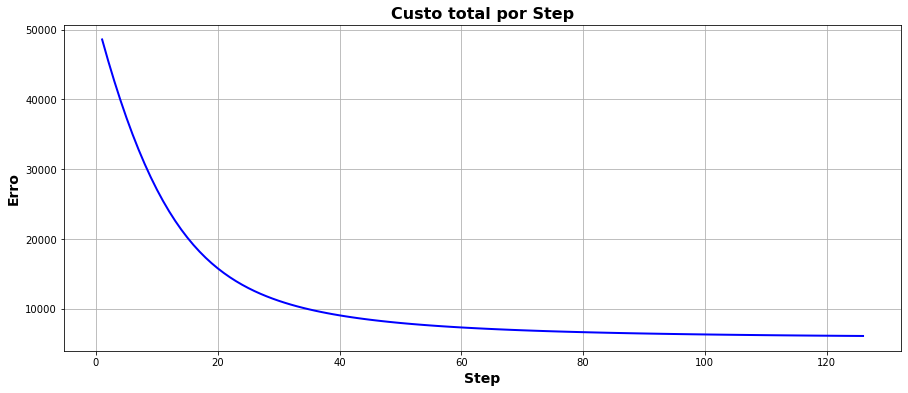

In [28]:
# Instanciando o modelo
fat = MatrixFactorization_mod(dataframe = dftrain, K = 5, steps = 500, alpha = 0.0001, beta = 0.2)

# Ajustando o modelo aos dados
fat.fit()

# Imprimindo o gráfico do erro em função dos passos
fat.print_MSE_steps()

In [29]:
print('A diferente entre o valor do último coeficiente MSE calculado, comparado ao anterior é igual a %s' \
%str(round(1 - (fat.lista_erro_step[-1] / fat.lista_erro_step[-2]), 6)))

A diferente entre o valor do último coeficiente MSE calculado, comparado ao anterior é igual a 0.000979


 Vemos que o modelo alcançou um patamar para o MSE após 125 passos (o valor varia sempre que o notebook é resetado e rodado), aproximadamente, dessa maneira, evitamos passos desnecessários e otimizamos o tempo de fatoração. Da mesma forma, testaremos agora com apenas 50 passos para a mesma configuração anterior.

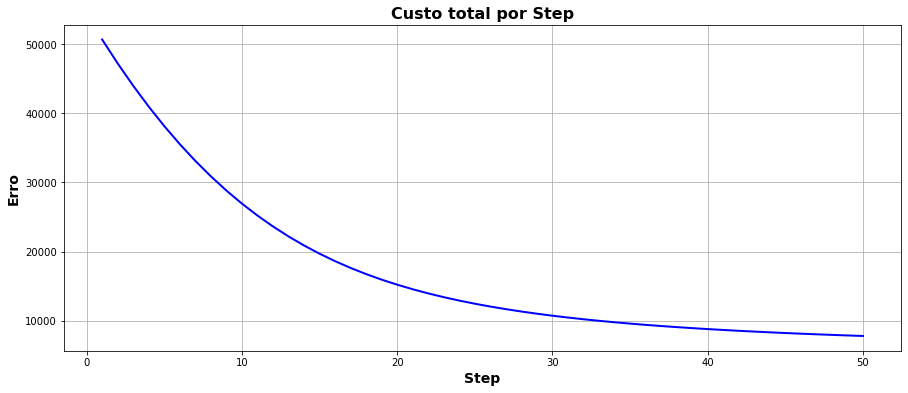

In [30]:
# Instanciando o modelo
fat = MatrixFactorization_mod(dataframe = dftrain, K = 5, steps = 50, alpha = 0.0001, beta = 0.2)

# Ajustando o modelo aos dados
fat.fit()

# Imprimindo o gráfico do erro em função dos passos
fat.print_MSE_steps()

In [31]:
print('A diferente entre o valor do último coeficiente MSE calculado, comparado ao anterior é igual a %s' \
%str(round(1 - (fat.lista_erro_step[-1] / fat.lista_erro_step[-2]), 6)))

A diferente entre o valor do último coeficiente MSE calculado, comparado ao anterior é igual a 0.009683


Para esse caso, como a diferença é superior ao valor padrão 0.001, a fatoração foi executada até o número de passos informado. Com isso em mente, consideraremos que o número de passos máximo será de 5000 e faremos uma busca pelos outros parâmetros para encontrar o melhor ajuste.

In [32]:
# Definindo intervalos
K_lista = [5, 10]
alpha_lista = np.linspace(0.0001, 0.01, 10)
beta_lista = np.linspace(0.1, 0.2, 10)
num_steps = 5000

# Listas para armazenar valores de cada parâmetro
lista_K = []
lista_alpha = []
lista_beta = []
lista_steps = []
lista_mse_train = []
lista_mse_val = []

t0 = time.time()
for item1 in K_lista:
    for item2 in alpha_lista:
        for item3 in beta_lista:
            # Instanciando modelo
            fat = MatrixFactorization_mod(dataframe = dftrain,
                                          K = item1,
                                          steps = num_steps,
                                          alpha = item2,
                                          beta = item3)
            
            # Ajustando modelo
            fat.fit()
            
            # Valores preditos
            predicted_values = fat.predict()
            
            # Valores de validação para comparação
            val_values = dfval.values
            
            rows_number, columns_number = val_values.shape
            mse_val = 0
            
            for i in range(0, rows_number):
                
                for j in range(0, columns_number):
                    # O erro só será calculado para os valores diferentes de zero dos dados de validação
                    if (val_values[i][j] != 0):
                        
                        #calculando o erro:
                        eij = predicted_values[i][j] - val_values[i][j]
                        mse_val += (eij)**2          
            
            lista_K.append(item1)
            lista_alpha.append(item2)
            lista_steps.append(fat.steps)
            lista_beta.append(item3)
            lista_mse_train.append(fat.lista_erro_step[-1])
            lista_mse_val.append(mse_val)

# Construindo um dataframe a partir dos valores obtidos.

df_resultados = pd.DataFrame(np.c_[lista_K, lista_alpha, lista_steps, lista_beta, lista_mse_train, lista_mse_val],
                            columns = ['K', 'Alpha', 'Steps', 'Beta', 'MSE_train', 'MSE_val'])

df_resultados['Diff_MSE'] = df_resultados['MSE_train'] - df_resultados['MSE_val']

t1 = time.time()
print('Tempo de execução aproximado: %s segundos.' %(str(round(t1 - t0, 0))))

Tempo de execução aproximado: 5363.0 segundos.


In [33]:
condition = df_resultados['MSE_train'] == df_resultados['MSE_train'].min()
index = df_resultados.index[condition][0]

df_resultados.iloc[index - 2: index + 3]

,K,Alpha,Steps,Beta,MSE_train,MSE_val,Diff_MSE
138,10.0,0.0034,171.0,0.188889,2829.480150,714.997858,2114.482292
139,10.0,0.0034,163.0,0.200000,2908.601084,701.271979,2207.329105
140,10.0,0.0045,151.0,0.100000,2218.124236,792.904563,1425.219673
141,10.0,0.0045,145.0,0.111111,2324.375846,799.405411,1524.970435
142,10.0,0.0045,145.0,0.122222,2408.583848,812.103393,1596.480455


In [34]:
condition_val = df_resultados['MSE_val'] == df_resultados['MSE_val'].min()
index_val = df_resultados.index[condition_val][0]

df_resultados.iloc[index_val - 2: index_val + 3]

,K,Alpha,Steps,Beta,MSE_train,MSE_val,Diff_MSE
15,5.0,0.0012,217.0,0.155556,4134.542683,654.192886,3480.349797
16,5.0,0.0012,216.0,0.166667,4183.556866,657.063560,3526.493306
17,5.0,0.0012,217.0,0.177778,4209.480234,645.869182,3563.611052
18,5.0,0.0012,214.0,0.188889,4302.821194,657.170509,3645.650685
19,5.0,0.0012,33.0,0.200000,5820.419193,649.978142,5170.441051


In [35]:
condition = df_resultados['Diff_MSE'] == df_resultados['Diff_MSE'].min()
index = df_resultados.index[condition][0]

df_resultados.iloc[index - 2: index + 3]

,K,Alpha,Steps,Beta,MSE_train,MSE_val,Diff_MSE
168,10.0,0.0067,111.0,0.188889,2788.252140,734.864792,2053.387348
169,10.0,0.0067,110.0,0.200000,2914.685887,716.375072,2198.310815
170,10.0,0.0078,125.0,0.100000,2269.340110,883.426763,1385.913347
171,10.0,0.0078,117.0,0.111111,2308.687674,828.536701,1480.150972
172,10.0,0.0078,103.0,0.122222,2405.376544,851.142988,1554.233556


Com base nos dataframes acima, vemos que quando o valor da MSE_train é mínimo, obtemos um valor elevado para o MSE_val e vice-versa. Com isso em mente, para selecionar os melhores parâmetros, consideraremos a média harmônica.

In [47]:
df_resultados['MedHarm_MSE'] = 2 * df_resultados['MSE_train'] * df_resultados['MSE_val'] / (df_resultados['MSE_train'] + df_resultados['MSE_val'])

condition = df_resultados['MedHarm_MSE'] == df_resultados['MedHarm_MSE'].min()
index = df_resultados.index[condition][0]

df_resultados.iloc[index - 2: index + 3]

,K,Alpha,Steps,Beta,MSE_train,MSE_val,Diff_MSE,MedHarm_MSE
127,10.0,0.0023,212.0,0.177778,2803.156033,717.861387,2085.294646,1143.009100
128,10.0,0.0023,201.0,0.188889,2908.473086,699.640482,2208.832603,1127.949813
129,10.0,0.0023,212.0,0.200000,2927.716792,668.298918,2259.417873,1088.198786
130,10.0,0.0034,176.0,0.100000,2290.426630,784.110853,1506.315777,1168.272229
131,10.0,0.0034,188.0,0.111111,2310.608829,824.983709,1485.625121,1215.856090


Na linha 129 temos o caso com a menor média harmônica. Aplicaremos os parâmetros ao modelo e testaremos com os dados de teste. Após isso, avaliaremos a MSE e compararemos com o valor MSE_val obtido.

In [49]:
fat_a = MatrixFactorization_mod(dataframe = dftrain,
                                K = 10,
                                steps = num_steps,
                                alpha = 0.0023,
                                beta = 0.2)
# Ajustando modelo
fat_a.fit()
            
# Valores preditos
predicted_values_a = fat_a.predict()
            
# Valores de validação para comparação
test_values = dftest.values
            
rows_number, columns_number = test_values.shape
mse_test = 0            
for i in range(0, rows_number):
    for j in range(0, columns_number):
    # O erro só será calculado para os valores diferentes de zero dos dados de validação
        if (test_values[i][j] != 0): 
            #calculando o erro:
            eij = predicted_values_a[i][j] - test_values[i][j]
            mse_test += (eij)**2
            
mse_test

673.1243308699228

In [59]:
# Criando dataframes com os valores preditos, de validação e de teste
df_pred_a = pd.DataFrame(np.c_[predicted_values_a], columns = R.columns, index = R.index)
df_val = pd.DataFrame(np.c_[val_values], columns = R.columns, index = R.index)
df_test = pd.DataFrame(np.c_[test_values], columns = R.columns, index = R.index)

Selecionando usuários aleatoriamente nos dados para verificar se podemos usar o modelo para recomendação.

In [85]:
index = np.random.randint(0, df_test.shape[0], size=11)

for i in index:
    print('*' * 10 + ' ' + df_test.index[i] + ' ' + '*' * 10)
    condition = df_test.iloc[i, :] != 0

    j = 0
    for item in condition:

        if item:
            print(df_test.columns[j])
            print('Valor predito: ', end= ' ')
            print(df_pred_a.iloc[i, j], end='\n')
            print('Valor real: ', end= ' ')
            print(df_test.iloc[i, j], end='\n')
            print('Diferença: ', end=' ')
            print((1 - df_pred_a.iloc[i, j]/df_test.iloc[i, j]) * 100, end=' ')
            print('%', end='\n\n')
            j += 1
        else:
            j += 1


********** User_171 **********
Filme_2
Valor predito:  3.5477032797731525
Valor real:  2.0
Diferença:  -77.38516398865762 %

Filme_56
Valor predito:  4.0011767360700405
Valor real:  5.0
Diferença:  19.976465278599186 %

********** User_27 **********
Filme_8
Valor predito:  3.7428215053813636
Valor real:  4.0
Diferença:  6.42946236546591 %

Filme_24
Valor predito:  3.4306904898817474
Valor real:  4.0
Diferença:  14.232737752956314 %

********** User_8 **********
Filme_58
Valor predito:  4.537321730746478
Valor real:  4.0
Diferença:  -13.433043268661947 %

Filme_76
Valor predito:  3.62020342250548
Valor real:  5.0
Diferença:  27.595931549890395 %

********** User_229 **********
Filme_42
Valor predito:  3.678780313092665
Valor real:  3.0
Diferença:  -22.626010436422163 %

Filme_49
Valor predito:  2.3321233641876993
Valor real:  2.0
Diferença:  -16.606168209384965 %

********** User_240 **********
Filme_5
Valor predito:  3.4722331918846536
Valor real:  4.0
Diferença:  13.19417020288366 %



Existem casos que apresentam grandes diferenças, como -77%, assim como aqueles que apresentam uma pequena diferença, como 2%. Os usuários acima representam 3% da população total de amostras. Entretanto, existem casos em que a diferença entre o valor predito e o valor de teste é de 200%. Vejamos se o modelo ajustado com os parâmetros que fornecem o menor valor de MSE_val apresenta melhores resultados.

In [86]:
fat_b = MatrixFactorization_mod(dataframe = dftrain,
                                K = 5,
                                steps = num_steps,
                                alpha = 0.0012,
                                beta = 0.177778)
# Ajustando modelo
fat_b.fit()
            
# Valores preditos
predicted_values_b = fat_b.predict()
            
# Valores de validação para comparação
test_values = dftest.values
            
rows_number, columns_number = test_values.shape
mse_test = 0            
for i in range(0, rows_number):
    for j in range(0, columns_number):
    # O erro só será calculado para os valores diferentes de zero dos dados de validação
        if (test_values[i][j] != 0): 
            #calculando o erro:
            eij = predicted_values_b[i][j] - test_values[i][j]
            mse_test += (eij)**2
            
mse_test

645.6511901268149

Vemos que o valor para o MSE para os dados de teste diminuiram em relação ao caso anterior. Vejamos como as predições se comportam, quando comparadas aos dados de testes selecionando alguns usuários aleatórios.

In [87]:
# Criando dataframe com os valores preditos
df_pred_b = pd.DataFrame(np.c_[predicted_values_b], columns = R.columns, index = R.index)

In [88]:
index = np.random.randint(0, df_test.shape[0], size=11)

for i in index:
    print('*' * 10 + ' ' + df_test.index[i] + ' ' + '*' * 10)
    condition = df_test.iloc[i, :] != 0

    j = 0
    for item in condition:

        if item:
            print(df_test.columns[j])
            print('Valor predito: ', end= ' ')
            print(df_pred_b.iloc[i, j], end='\n')
            print('Valor real: ', end= ' ')
            print(df_test.iloc[i, j], end='\n')
            print('Diferença: ', end=' ')
            print((1 - df_pred_b.iloc[i, j]/df_test.iloc[i, j]) * 100, end=' ')
            print('%', end='\n\n')
            j += 1
        else:
            j += 1


********** User_134 **********
Filme_11
Valor predito:  3.4774876105967762
Valor real:  4.0
Diferença:  13.062809735080593 %

Filme_44
Valor predito:  3.1329620287052835
Valor real:  4.0
Diferença:  21.675949282367913 %

********** User_335 **********
Filme_73
Valor predito:  3.2922437451914304
Valor real:  1.0
Diferença:  -229.22437451914303 %

Filme_80
Valor predito:  2.580182571790588
Valor real:  2.0
Diferença:  -29.009128589529396 %

********** User_188 **********
Filme_3
Valor predito:  2.370645143515755
Valor real:  2.0
Diferença:  -18.53225717578775 %

Filme_7
Valor predito:  2.952703648280516
Valor real:  4.0
Diferença:  26.1824087929871 %

********** User_15 **********
Filme_58
Valor predito:  3.5875596943191828
Valor real:  3.0
Diferença:  -19.585323143972765 %

Filme_64
Valor predito:  4.382275129289347
Valor real:  5.0
Diferença:  12.35449741421306 %

********** User_49 **********
Filme_12
Valor predito:  3.9598527832339223
Valor real:  4.0
Diferença:  1.0036804191519422 %

Percebemos que existem valores que apresentam diferença superior a 200%, assim como no caso anterior, e valores com pequenas diferenças, próximo de 1%. Como o ganho de desempenho não é significativo (os valores de MSE para os dados de teste são próximos), o modelo mais adequado para recomendação é o configurado com os seguintes parâmetros:

- K = 10
- $\alpha$ = 0.0023
- $\beta$ = 0.2

onde o número de steps depende da convergência do valor de MSE.

Podemos realizar um teste aumentando a quantidade de dados que são selecionados dos dados originais.

In [90]:
# Usando a função train_test_split definida no notebook, separaremos os dados em treino, validação e teste.
train, test = train_test_split(ratings, qtd = 4)
train, val = train_test_split(train, qtd = 4)

dftrain, dfval, dftest = getDataFrame(train_data = train, val_data = val, test_data = test,
                                     columns_name = R.columns, index_name = R.index)

# Definindo intervalos
K_lista = [5, 10]
alpha_lista = np.linspace(0.0001, 0.01, 10)
beta_lista = np.linspace(0.1, 0.2, 10)
num_steps = 5000

# Listas para armazenar valores de cada parâmetro
lista_K = []
lista_alpha = []
lista_beta = []
lista_steps = []
lista_mse_train = []
lista_mse_val = []

t0 = time.time()
for item1 in K_lista:
    for item2 in alpha_lista:
        for item3 in beta_lista:
            # Instanciando modelo
            fat = MatrixFactorization_mod(dataframe = dftrain,
                                          K = item1,
                                          steps = num_steps,
                                          alpha = item2,
                                          beta = item3)
            
            # Ajustando modelo
            fat.fit()
            
            # Valores preditos
            predicted_values = fat.predict()
            
            # Valores de validação para comparação
            val_values = dfval.values
            
            rows_number, columns_number = val_values.shape
            mse_val = 0
            
            for i in range(0, rows_number):
                
                for j in range(0, columns_number):
                    # O erro só será calculado para os valores diferentes de zero dos dados de validação
                    if (val_values[i][j] != 0):
                        
                        #calculando o erro:
                        eij = predicted_values[i][j] - val_values[i][j]
                        mse_val += (eij)**2          
            
            lista_K.append(item1)
            lista_alpha.append(item2)
            lista_steps.append(fat.steps)
            lista_beta.append(item3)
            lista_mse_train.append(fat.lista_erro_step[-1])
            lista_mse_val.append(mse_val)

# Construindo um dataframe a partir dos valores obtidos.

df_resultados = pd.DataFrame(np.c_[lista_K, lista_alpha, lista_steps, lista_beta, lista_mse_train, lista_mse_val],
                            columns = ['K', 'Alpha', 'Steps', 'Beta', 'MSE_train', 'MSE_val'])

df_resultados['Diff_MSE'] = df_resultados['MSE_train'] - df_resultados['MSE_val']

t1 = time.time()
print('Tempo de execução aproximado: %s segundos.' %(str(round(t1 - t0, 0))))

Tempo de execução aproximado: 5019.0 segundos.


Assim como no caso anterior, usaremos a média harmônica para avaliar o resultado.

In [91]:
df_resultados['MedHarm_MSE'] = 2 * df_resultados['MSE_train'] * df_resultados['MSE_val'] / (df_resultados['MSE_train'] + df_resultados['MSE_val'])

condition = df_resultados['MedHarm_MSE'] == df_resultados['MedHarm_MSE'].min()
index = df_resultados.index[condition][0]

df_resultados.iloc[index - 2: index + 3]

,K,Alpha,Steps,Beta,MSE_train,MSE_val,Diff_MSE,MedHarm_MSE
129,10.0,0.0023,227.0,0.200000,2095.332170,1456.417218,638.914952,1718.408320
130,10.0,0.0034,224.0,0.100000,1512.780116,1704.032508,-191.252392,1602.720951
131,10.0,0.0034,201.0,0.111111,1548.400242,1581.735698,-33.335456,1564.890461
132,10.0,0.0034,191.0,0.122222,1648.027343,1633.363759,14.663584,1640.662787
133,10.0,0.0034,189.0,0.133333,1655.112345,1640.202967,14.909378,1647.623928


In [92]:
fat_c = MatrixFactorization_mod(dataframe = dftrain,
                                K = 10,
                                steps = num_steps,
                                alpha = 0.0034,
                                beta = 0.111111)
# Ajustando modelo
fat_c.fit()
            
# Valores preditos
predicted_values_c = fat_c.predict()
            
# Valores de validação para comparação
test_values = dftest.values
            
rows_number, columns_number = test_values.shape
mse_test = 0            
for i in range(0, rows_number):
    for j in range(0, columns_number):
    # O erro só será calculado para os valores diferentes de zero dos dados de validação
        if (test_values[i][j] != 0): 
            #calculando o erro:
            eij = predicted_values_c[i][j] - test_values[i][j]
            mse_test += (eij)**2
            
mse_test

1698.2585254699309

In [93]:
# Criando dataframes com os valores preditos, de validação e de teste
df_pred_c = pd.DataFrame(np.c_[predicted_values_c], columns = R.columns, index = R.index)
df_val = pd.DataFrame(np.c_[val_values], columns = R.columns, index = R.index)
df_test = pd.DataFrame(np.c_[test_values], columns = R.columns, index = R.index)

In [96]:
index = np.random.randint(0, df_test.shape[0], size=11)

for i in index:
    print('*' * 10 + ' ' + df_test.index[i] + ' ' + '*' * 10)
    condition = df_test.iloc[i, :] != 0

    j = 0
    for item in condition:

        if item:
            print(df_test.columns[j])
            print('Valor predito: ', end= ' ')
            print(df_pred_c.iloc[i, j], end='\n')
            print('Valor real: ', end= ' ')
            print(df_test.iloc[i, j], end='\n')
            print('Diferença: ', end=' ')
            print((1 - df_pred_c.iloc[i, j]/df_test.iloc[i, j]) * 100, end=' ')
            print('%', end='\n\n')
            j += 1
        else:
            j += 1


********** User_211 **********
Filme_13
Valor predito:  3.6607867777126692
Valor real:  3.0
Diferença:  -22.02622592375565 %

Filme_26
Valor predito:  3.452520039499
Valor real:  3.0
Diferença:  -15.084001316633323 %

Filme_64
Valor predito:  4.485360441429654
Valor real:  4.0
Diferença:  -12.134011035741343 %

Filme_79
Valor predito:  4.659336746676982
Valor real:  4.0
Diferença:  -16.483418666924553 %

********** User_245 **********
Filme_8
Valor predito:  3.993822092470231
Valor real:  4.0
Diferença:  0.15444768824423027 %

Filme_50
Valor predito:  4.59372006361719
Valor real:  4.0
Diferença:  -14.84300159042975 %

Filme_71
Valor predito:  3.130687236579128
Valor real:  4.0
Diferença:  21.732819085521804 %

Filme_79
Valor predito:  4.025060209933216
Valor real:  3.0
Diferença:  -34.16867366444052 %

********** User_353 **********
Filme_7
Valor predito:  4.194641909545341
Valor real:  2.0
Diferença:  -109.73209547726705 %

Filme_12
Valor predito:  4.6729596829922215
Valor real:  5.0


Aumentando a quantidade de itens armazenados para teste, validação e treino, vemos pelos resultados acima que o valor da MSE permanece aproximadamente o mesmo para os dados de treino e validação, enquanto apresenta um aumento de 9%. Através da amostragem acima, vemos que é possível alcançar valores com diferença de 0,01% até 150%

Avaliando o modelo que apresenta menor valor para MSE_val, vemos que o valor para o MSE dos dados de treino é bastante elevado. Vejamos como o modelo se comporta.

In [97]:
condition_val = df_resultados['MSE_val'] == df_resultados['MSE_val'].min()
index_val = df_resultados.index[condition_val][0]

df_resultados.iloc[index_val - 2: index_val + 3]

,K,Alpha,Steps,Beta,MSE_train,MSE_val,Diff_MSE,MedHarm_MSE
99,5.0,0.0100,71.0,0.200000,3170.049418,1514.902675,1655.146744,2050.102647
100,10.0,0.0001,136.0,0.100000,4678.737746,1363.035175,3315.702571,2111.063823
101,10.0,0.0001,138.0,0.111111,4648.243486,1354.006238,3294.237248,2097.130565
102,10.0,0.0001,140.0,0.122222,4739.170793,1411.009764,3328.161030,2174.575591
103,10.0,0.0001,135.0,0.133333,4699.170492,1387.893277,3311.277216,2142.887730


In [98]:
fat_c = MatrixFactorization_mod(dataframe = dftrain,
                                K = 10,
                                steps = num_steps,
                                alpha = 0.0001,
                                beta = 0.111111)
# Ajustando modelo
fat_c.fit()
            
# Valores preditos
predicted_values_c = fat_c.predict()
            
# Valores de validação para comparação
test_values = dftest.values
            
rows_number, columns_number = test_values.shape
mse_test = 0            
for i in range(0, rows_number):
    for j in range(0, columns_number):
    # O erro só será calculado para os valores diferentes de zero dos dados de validação
        if (test_values[i][j] != 0): 
            #calculando o erro:
            eij = predicted_values_c[i][j] - test_values[i][j]
            mse_test += (eij)**2
            
mse_test

1446.3199331130397

In [99]:
# Criando dataframes com os valores preditos, de validação e de teste
df_pred_c = pd.DataFrame(np.c_[predicted_values_c], columns = R.columns, index = R.index)
df_val = pd.DataFrame(np.c_[val_values], columns = R.columns, index = R.index)
df_test = pd.DataFrame(np.c_[test_values], columns = R.columns, index = R.index)

In [100]:
index = np.random.randint(0, df_test.shape[0], size=11)

for i in index:
    print('*' * 10 + ' ' + df_test.index[i] + ' ' + '*' * 10)
    condition = df_test.iloc[i, :] != 0

    j = 0
    for item in condition:

        if item:
            print(df_test.columns[j])
            print('Valor predito: ', end= ' ')
            print(df_pred_c.iloc[i, j], end='\n')
            print('Valor real: ', end= ' ')
            print(df_test.iloc[i, j], end='\n')
            print('Diferença: ', end=' ')
            print((1 - df_pred_c.iloc[i, j]/df_test.iloc[i, j]) * 100, end=' ')
            print('%', end='\n\n')
            j += 1
        else:
            j += 1


********** User_215 **********
Filme_7
Valor predito:  3.8266457502366173
Valor real:  5.0
Diferença:  23.46708499526765 %

Filme_14
Valor predito:  3.631094127602009
Valor real:  2.0
Diferença:  -81.55470638010046 %

Filme_23
Valor predito:  3.935078824706298
Valor real:  5.0
Diferença:  21.29842350587403 %

Filme_56
Valor predito:  3.843068195515864
Valor real:  4.0
Diferença:  3.9232951121033977 %

********** User_189 **********
Filme_1
Valor predito:  3.9017784480506044
Valor real:  4.0
Diferença:  2.455538798734891 %

Filme_8
Valor predito:  3.6495998903151934
Valor real:  4.0
Diferença:  8.760002742120164 %

Filme_12
Valor predito:  3.8657272412899064
Valor real:  4.0
Diferença:  3.3568189677523397 %

Filme_56
Valor predito:  3.8037970728319888
Valor real:  4.0
Diferença:  4.905073179200281 %

********** User_249 **********
Filme_7
Valor predito:  3.6054536482366113
Valor real:  5.0
Diferença:  27.890927035267776 %

Filme_8
Valor predito:  3.609030031296787
Valor real:  4.0
Difer

A maior e menor diferença apresentada para o caso acima foi bastante similar ao anterior: 150% e 0.01%. Apesar da diminuição do MSE, o modelo escolhido é o baseado na média harmônica das MSE de treino e validação. Sendo assim, os valores dos parâmetros ideais são:

- K = 10
- $\alpha$ = 0.0034
- $\beta$ = 0.11111

onde o número de steps depende da convergência do valor de MSE.

### Conclusões

Os resultados discutidos ao longo deste notebook mostraram que a medida em que a MSE_train aumentava, a MSE_val diminuia. Com o intuito de minimizar a MSE em geral, foi escolhida como métrica a média harmônica entre MSE_train e MSE_val. Dessa maneira, obtivemos os valores de MSE para os dados de treino e validação que não representam nem o mínimo, nem o máximo de cada um deles, mas sim, a combinação que apresentou maior consistência do modelo.

Para otimizar a escolha do modelo, foi adicionado um critério de parada para evitar cálculos desnecessários. Quando o MSE calculado para o valor atual for diferente em 0,1% ou menos do valor anterior, os cálculos são parados e são testados os próximos parâmetros, sendo assim, para cada parâmetro, o número de passo variou. Essas informações podem ser vistas nos dataframes "df_resultados" para cada um dos modelos.

Com isso em mente, chegamos a dois modelos:

__Primeiro caso:__ Quantidade de amostras retiradas por usuário: 2

Parâmetros usados:

- K = 10
- $\alpha$ = 0.0023
- $\beta$ = 0.2
- numéro de passos: máximo = 5000

__Segundo caso:__ Quantidade de amostras retiradas por usuário: 4

Parâmetros usados:

- K = 10
- $\alpha$ = 0.0034
- $\beta$ = 0.111111
- numéro de passos: máximo = 5000

A partir destes dois casos, vemos que o segundo  modelo se comporta melhor, mesmo apresentando MSE superior. Isso ocorre, devido ao aumento do número de dados de validação e teste. Através da amostragem, vemos que o modelo se comporta melhor que os outros apresentados, uma vez que, para um mesmo usuário, a diferença máxima e mínima são, aproximadamente, da mesma grandeza. Sendo assim, o modelo escolhido para a recomendação é aquele que apresenta o ajusta considerando os parâmetros apresentados no __segundo caso__.